# Preliminary analysis of RCA in vivo conditions

In [1]:
import os, sys
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import colorcet as cc
import cv2
import skimage
import scipy.ndimage, scipy.stats

In [2]:
from cellpose import models, utils

## Set up directory

In [3]:
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif"

# list of all files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, f) for f in files if f.endswith('.tif')]
files.sort()
files

['/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_001.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_002.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_003.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_004.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_005.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_006.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_007.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_008.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_009.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC

In [4]:
file = files[1]
print(file)
img = tif.imread(file)
img_nuc = img[11,:,:]
img_488 = img[10,:,:]
img_555 = img[9,:,:]

/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/tif/ROI_002.tif


## Exploratory analysis

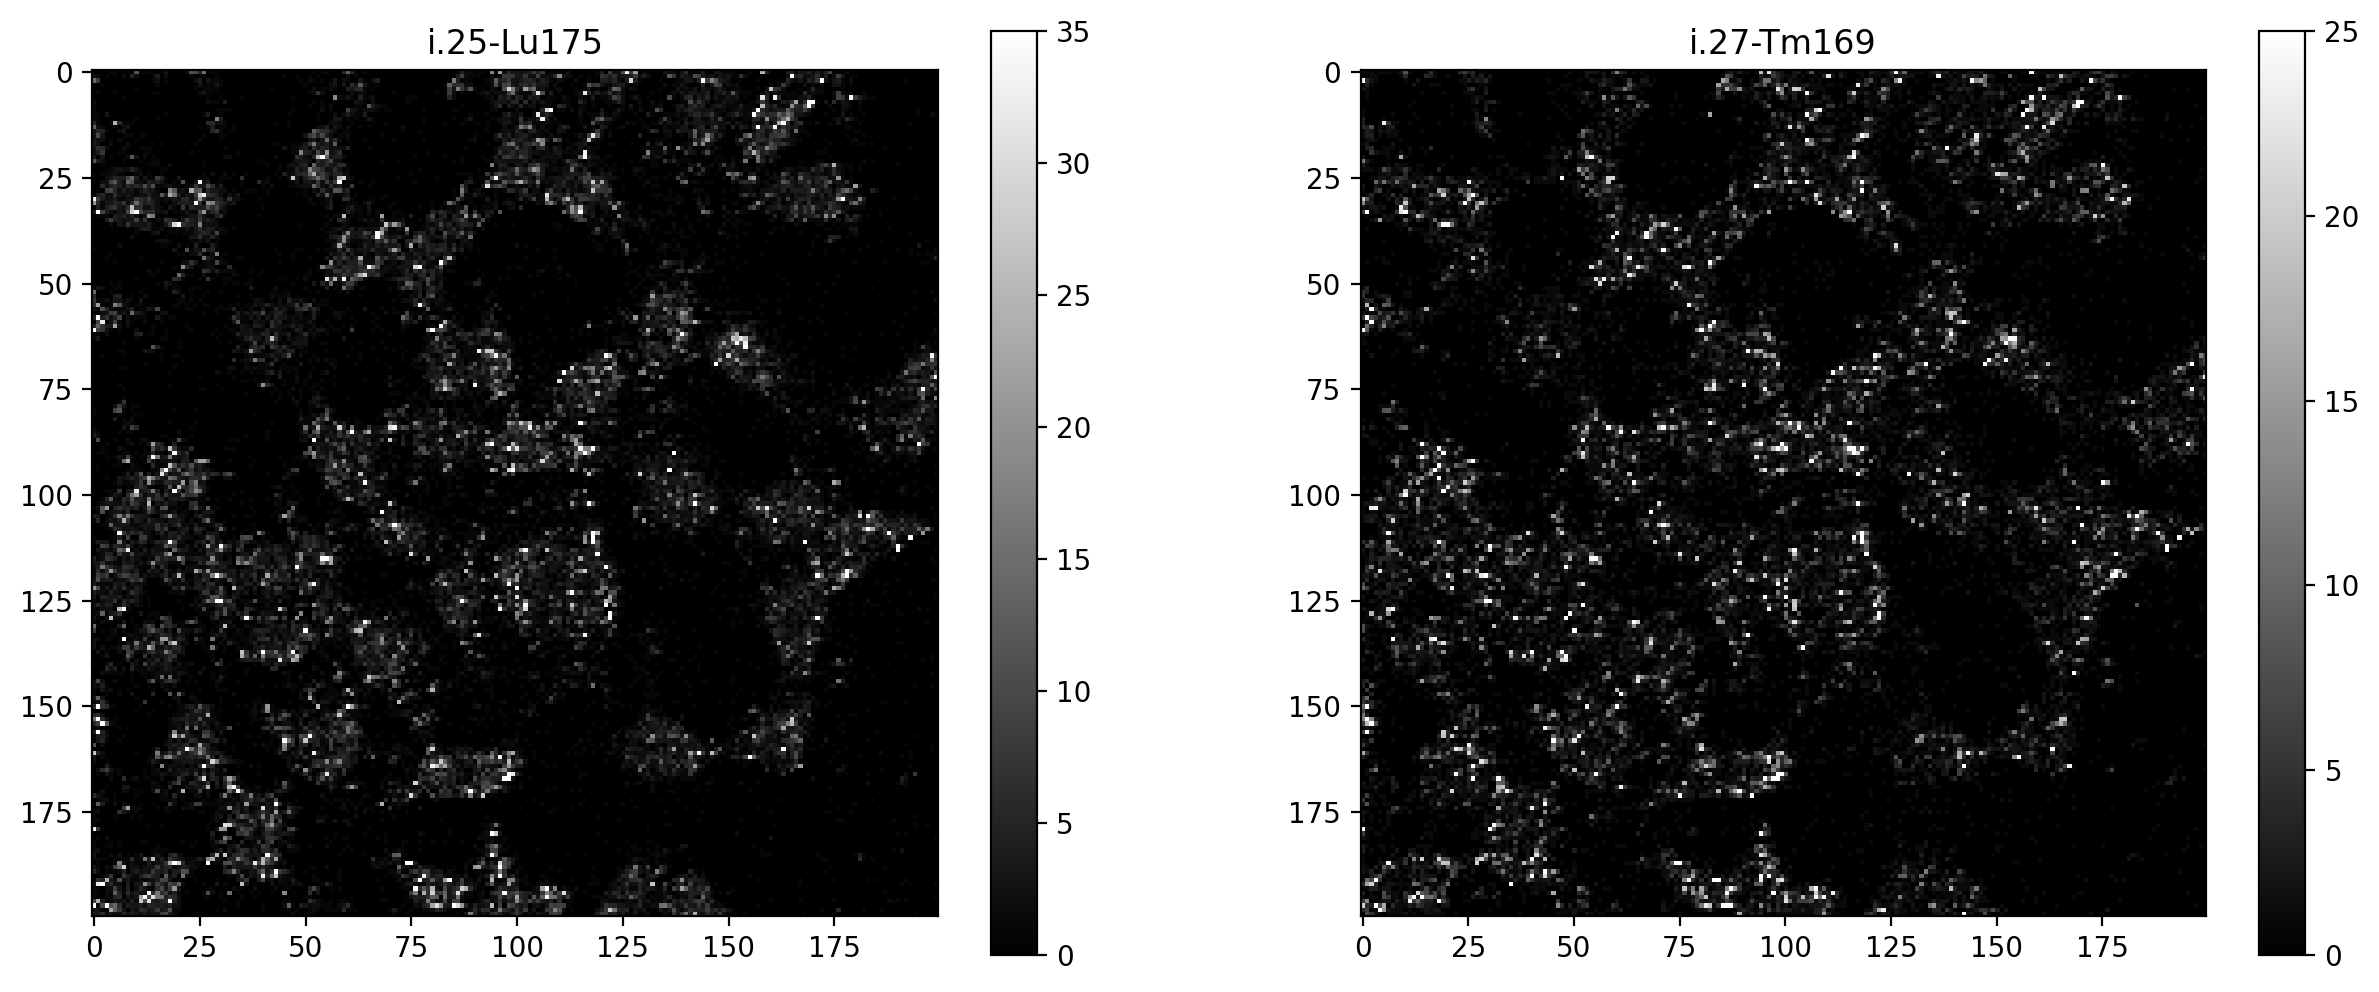

In [5]:
plt.figure(figsize=(15, 6), dpi = 200)
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.title("i.25-Lu175")
plt.clim(0, 35)
plt.colorbar()
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.title("i.27-Tm169")
plt.clim(0, 25)
plt.colorbar()
plt.show()

Plot a line profile in the diagonal direction

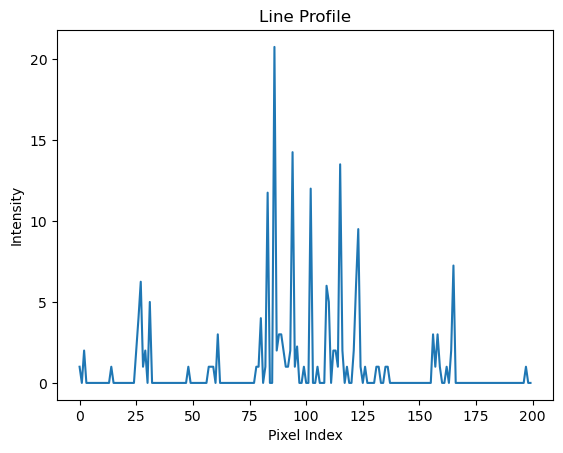

In [6]:
def plot_line_profile(img, start, end):
    # Create a mask for the line
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.line(mask, start, end, 255, 1)

    # Get the coordinates of the line
    coords = np.column_stack(np.where(mask > 0))

    # Get the pixel values along the line
    line_values = img[coords[:, 0], coords[:, 1]]

    # Plot the line profile
    plt.plot(line_values)
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.title('Line Profile')
    plt.show()
# Define the start and end points of the line
start = (0, 0)
end = (img_488.shape[1] - 1, img_488.shape[0] - 1)
# Plot the line profile for the first image
plot_line_profile(img_555, start, end)

## Amplicon masking and binarization

Difference of guassian and then local maxima to detect spots

In [7]:
def vis_roll_ball(img, radius):
    # slightly blur the image to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # rolling ball algorithm to remove background
    background = skimage.restoration.rolling_ball(img, radius=radius)
    img_sub = img - background
    
    # set figure size
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.clim(np.percentile(img, 5), np.percentile(img, 99.9))
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(background, cmap='gray')
    plt.title('Background')
    plt.clim(np.percentile(background, 5), np.percentile(background, 99.9))
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_sub, cmap='gray')
    plt.title('Subtracted Image')
    plt.clim(np.percentile(img_sub, 5), np.percentile(img_sub, 99.9))
    plt.axis('off')

    plt.show()

    start = (0, 0)
    end = (img_sub.shape[1] - 1, img_sub.shape[0] - 1)
    plot_line_profile(img_sub, start, end)
    
def vis_gaussian(img, sigma1, sigma2):
    # difference of guassian sigma1 = 2, sigma2 = 10
    img_sig1 = skimage.filters.gaussian(img, sigma=sigma1, preserve_range=True)
    img_sig2 = skimage.filters.gaussian(img, sigma=sigma2, preserve_range=True)
    img_sub = img_sig1 - img_sig2
    
    return img_sub

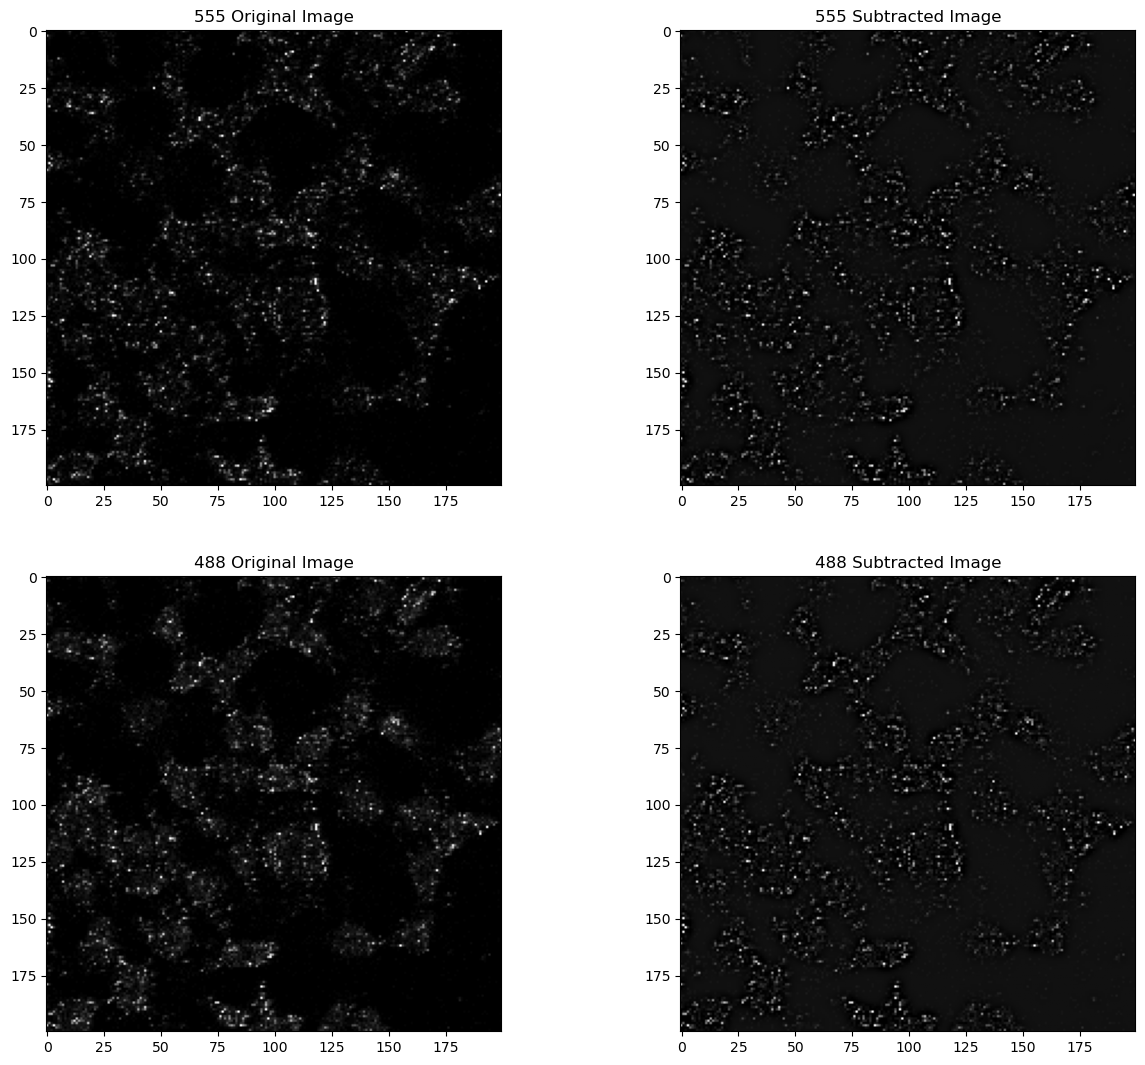

In [8]:
sigma_1 = 0
sigma_2 = 2


img_555_sub = vis_gaussian(img_555, sigma_1, sigma_2)
img_488_sub = vis_gaussian(img_488, sigma_1, sigma_2)

plt.figure(figsize=(15, 13), dpi=100)
plt.subplot(221)
plt.imshow(img_555, cmap='gray')
plt.title('555 Original Image')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
# plt.axis('off')
plt.subplot(222)
plt.imshow(img_555_sub, cmap='gray')
plt.title('555 Subtracted Image')
plt.clim(np.percentile(img_555_sub, 5), np.percentile(img_555_sub, 99.9))
# plt.axis('off')
plt.subplot(223)
plt.imshow(img_488, cmap='gray')
plt.title('488 Original Image')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
# plt.axis('off')
plt.subplot(224)
plt.imshow(img_488_sub, cmap='gray')
plt.title('488 Subtracted Image')
plt.clim(np.percentile(img_488_sub, 5), np.percentile(img_488_sub, 99.9))
# plt.axis('off')
plt.show()

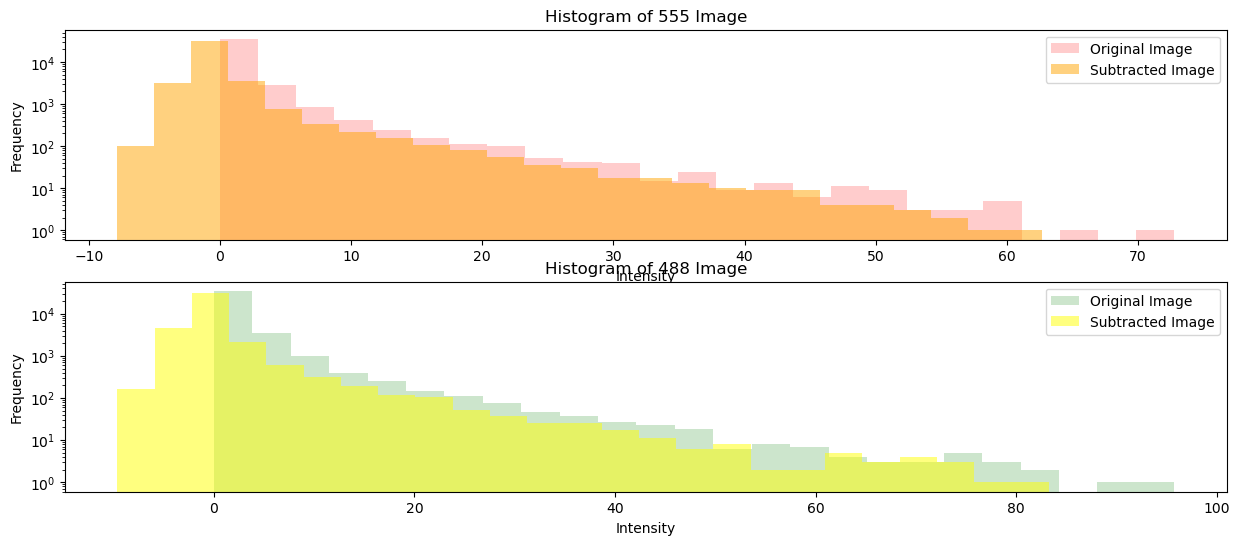

In [9]:

# plot the histogram before and after background subtraction
plt.figure(figsize=(15, 6), dpi=100)
plt.subplot(211)
# plt.hist(img_555_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_555.flatten(), bins=25, color='red', alpha=0.2, label='Original Image')
plt.hist(img_555_sub.flatten(), bins=25, color='orange', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 555 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
# set y into log
plt.yscale('log')
plt.legend()
plt.subplot(212)
# plt.hist(img_488_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_488.flatten(), bins=25, color='green', alpha=0.2, label='Original Image')
plt.hist(img_488_sub.flatten(), bins=25, color='yellow', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 488 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()

Local max (circular kernel)

In [10]:
def maximum_filter(img, radius):
    # set a circular kernel
    kernel = cv2.circle(np.zeros((radius*2+1, radius*2+1), dtype=np.uint8), (radius, radius), radius, 1, -1)
    
    # apply the maximum filter using the circular kernel, consider a reflective border
    img_max = cv2.dilate(img, kernel, iterations=1)
    return img_max

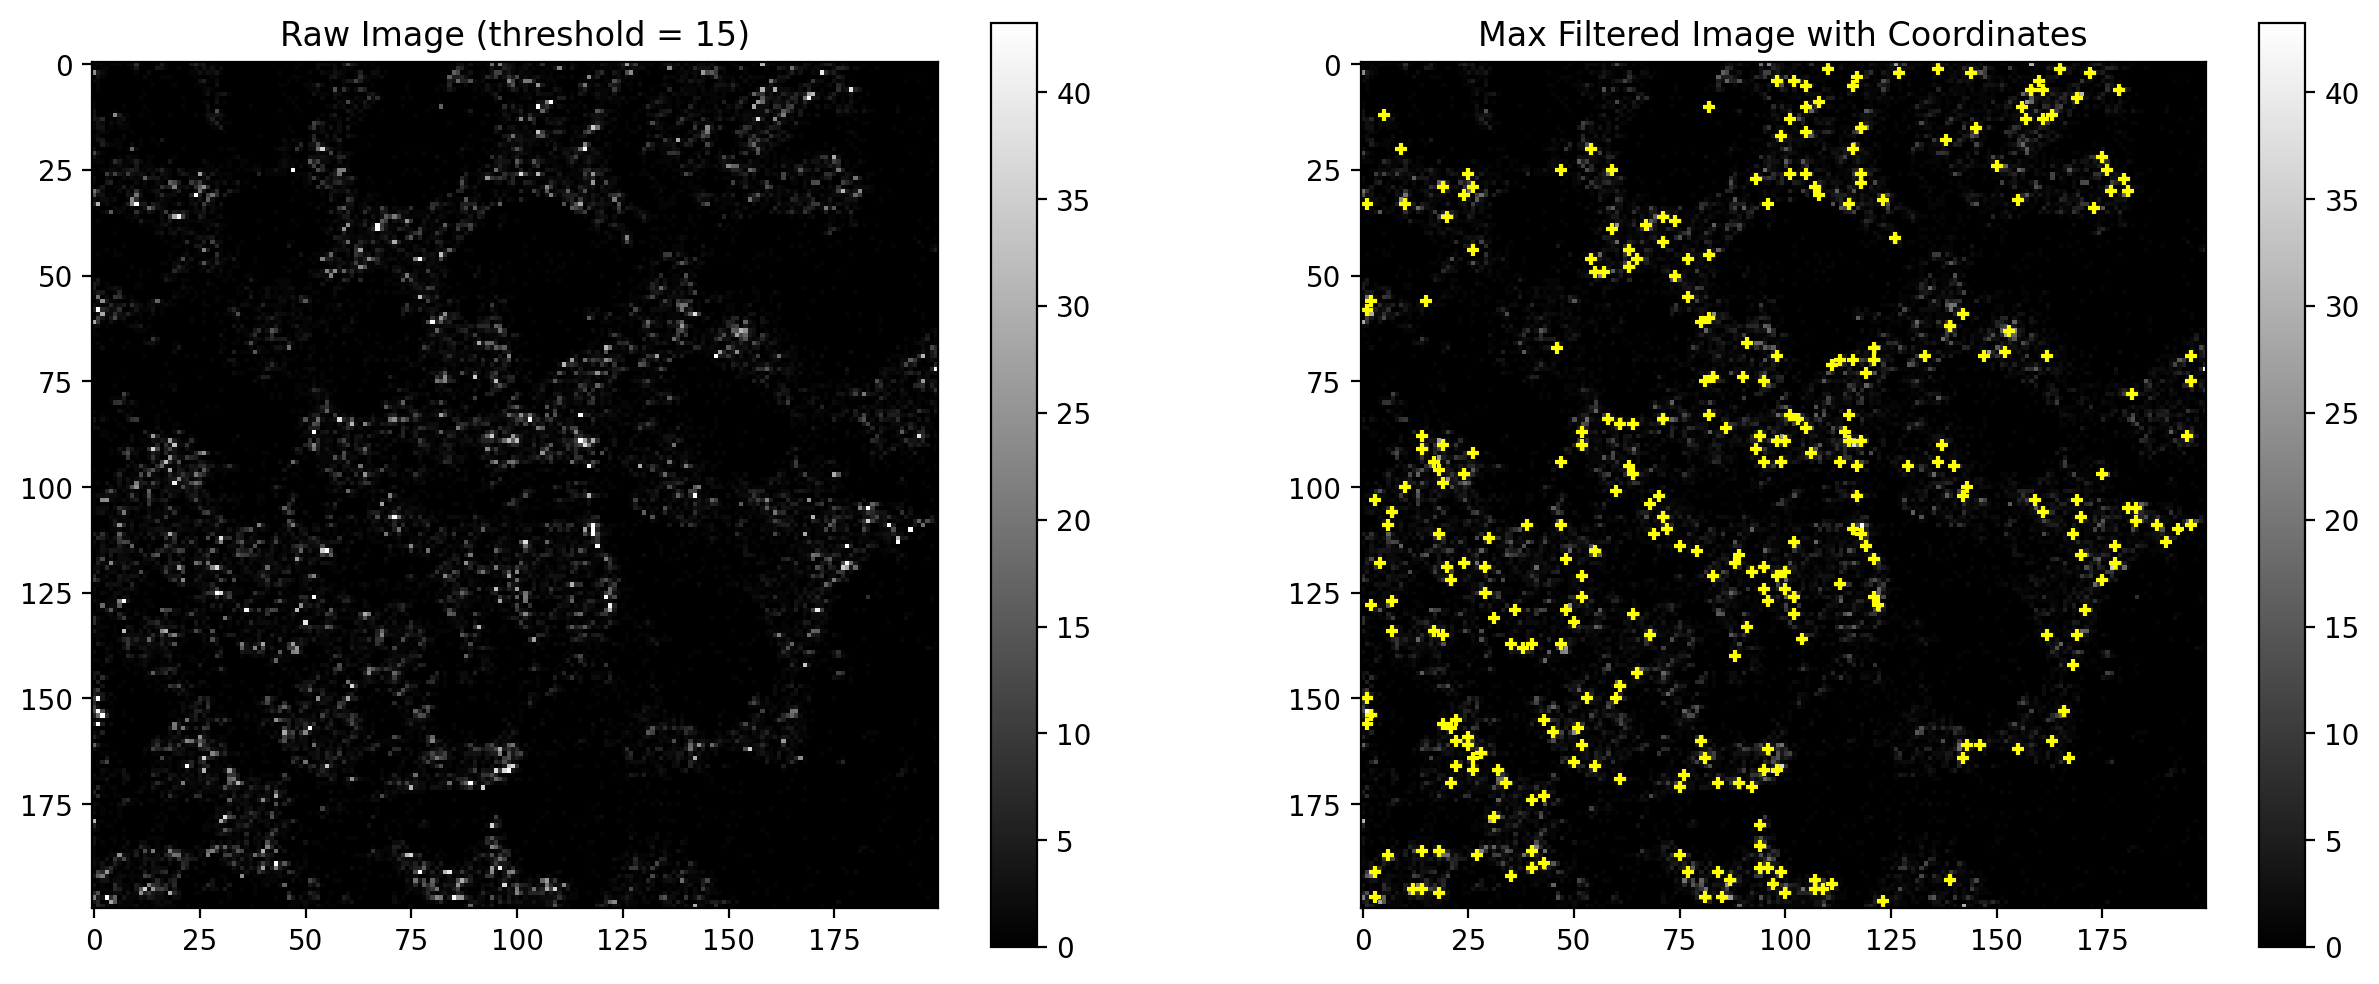

In [11]:
# img_555_max = scipy.ndimage.maximum_filter(img_555_sub, size=5)
# img_555_max = maximum_filter(img_555_sub, radius=0)
img_555_max = maximum_filter(img_555, radius=0)
thres = 15
coordinates = skimage.feature.peak_local_max(img_555_sub, min_distance=1, threshold_abs=thres)

plt.figure(figsize=(15, 6), dpi=200)
plt.subplot(121)
plt.imshow(img_555_max, cmap='gray')
plt.title('Raw Image (threshold = {})'.format(thres))
plt.clim(np.percentile(img_555_max, 5), np.percentile(img_555_max, 99.9))
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
plt.colorbar()

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('Max Filtered Image with Coordinates')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))

plt.colorbar()
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
    
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
    
plt.show()

Coarse peak intensity correlation

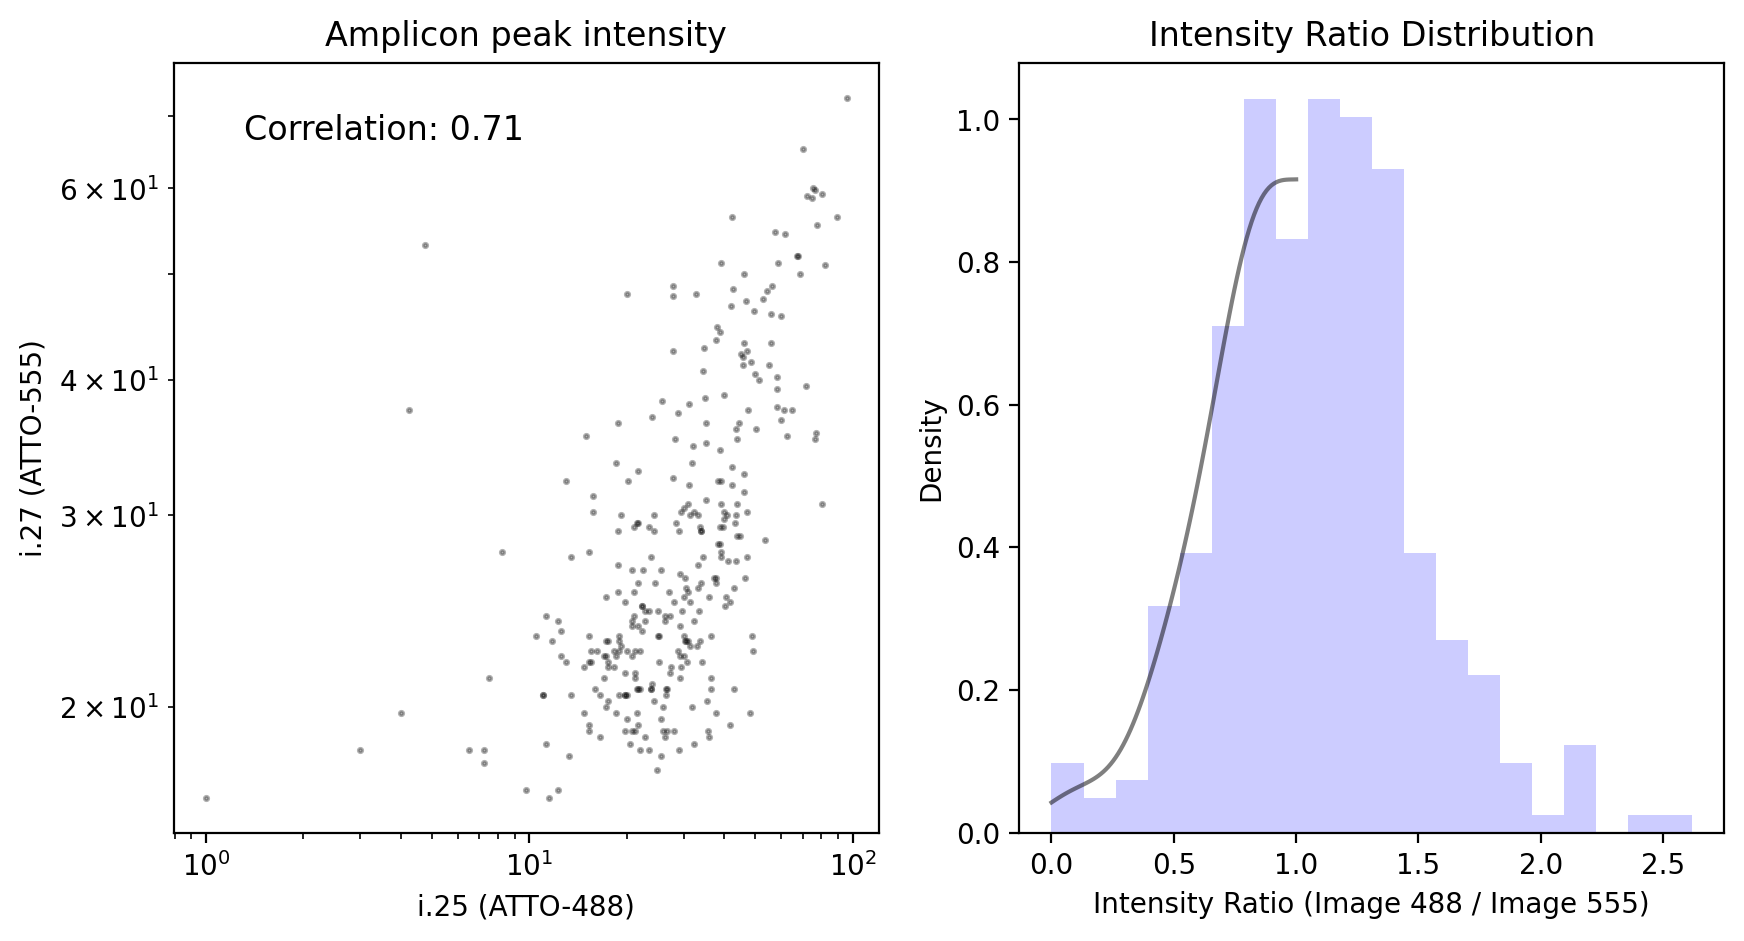

In [12]:
# plot a scatter plot correlating the intensity of img_488 and img_555 in the same coordinates
def plot_scatter(img1, img2, coordinates):
    # Get the pixel values at the coordinates
    values1 = img1[coordinates[:, 0], coordinates[:, 1]]
    values2 = img2[coordinates[:, 0], coordinates[:, 1]]

    # remove data pair if any of them is higher than 60000
    mask = (values1 < 60000) & (values2 < 60000)
    values1 = values1[mask]
    values2 = values2[mask]
    
    # ratio
    ratio = values1/values2
    
    # Plot the scatter plot
    plt.figure(figsize=(10,5), dpi = 200)
    plt.subplot(121)
    plt.scatter(values1, values2, c='black', s=10, alpha=0.3, marker='.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('i.25 (ATTO-488)')
    plt.ylabel('i.27 (ATTO-555)')
    plt.title('Amplicon peak intensity')
    # compute the correlation coefficient
    correlation = np.corrcoef(values1, values2)[0, 1]
    plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.subplot(122)
    # plot a smoothened histogram of the intensity ratio
    plt.hist(ratio, bins=20, color='blue', alpha=0.2, density=True)
    kde = scipy.stats.gaussian_kde(ratio)
    x = np.linspace(0, 1, 100)
    plt.plot(x, kde(x), color='black', alpha=0.5)
    plt.xlabel('Intensity Ratio (Image 488 / Image 555)')
    plt.ylabel('Density')
    plt.title('Intensity Ratio Distribution')
    
    plt.show()
    
    
    
# Convert coordinates to a numpy array
coordinates = np.array(coordinates)
# Plot the scatter plot
plot_scatter(img_488, img_555, coordinates)

whole-amplicon intensity correlation

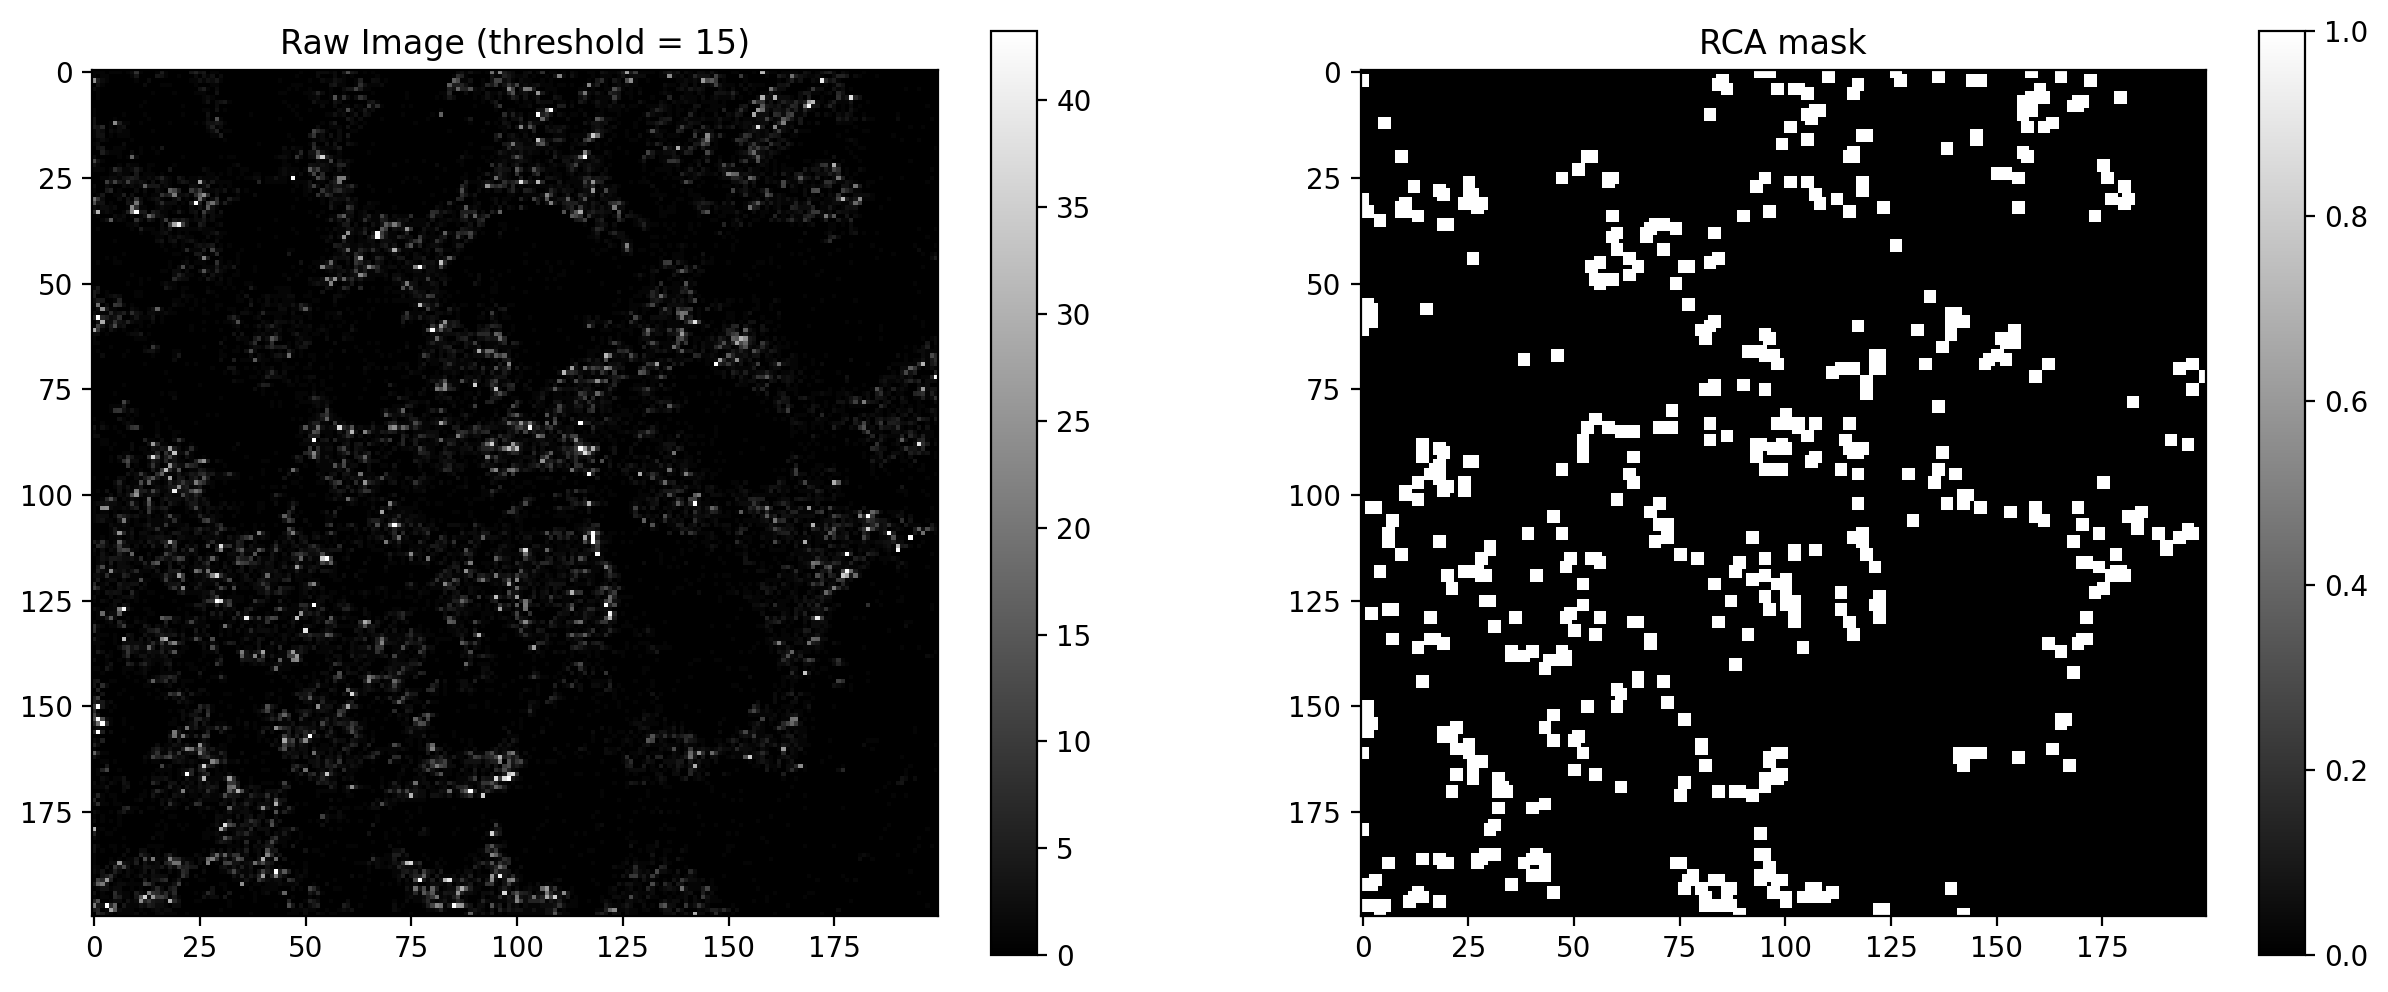

In [13]:
img_mask = img_555_max > thres
# dilate the mask
kernel = np.ones((3, 3), np.uint8)
img_mask = cv2.dilate(img_mask.astype(np.uint8), kernel, iterations=1)

plt.figure(figsize=(15, 6), dpi=200)
plt.subplot(121)
plt.imshow(img_555_max, cmap='gray')
plt.title('Raw Image (threshold = {})'.format(thres))
plt.clim(np.percentile(img_555_max, 5), np.percentile(img_555_max, 99.9))
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
plt.colorbar()

plt.subplot(122)
plt.imshow(img_mask, cmap='gray')
plt.title('RCA mask')
plt.clim(0, 1)
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
plt.colorbar()

plt.show()

In [14]:
# turn the mask into a label image
img_mask = skimage.measure.label(img_mask)
img_488_df = skimage.measure.regionprops_table(img_mask, img_488, properties=['label', 'centroid', 'area', 'mean_intensity'])
img_555_df = skimage.measure.regionprops_table(img_mask, img_555, properties=['label', 'centroid', 'area', 'mean_intensity'])

In [15]:
img_488_df = pd.DataFrame(img_488_df)
img_555_df = pd.DataFrame(img_555_df)

# add one column to store area*mean_intensity as total_intensity
img_488_df['total_intensity'] = img_488_df['area'] * img_488_df['mean_intensity']
img_555_df['total_intensity'] = img_555_df['area'] * img_555_df['mean_intensity']

# merge the two dataframes on label, keep area, centroid-0, centroid-1 only from img_488_df, the rest add the suffixes
amp_df = pd.merge(img_488_df, img_555_df, on='label', suffixes=('_488', '_555'))

amp_df.rename(columns={'area_488': 'area', 'centroid-0_488': 'centroid-0', 'centroid-1_488': 'centroid-1'}, inplace=True)
amp_df.drop(columns=['area_555', 'centroid-0_555', 'centroid-1_555'], inplace=True)

# change the column name "centroid-0" to "y"
amp_df.rename(columns={'centroid-0': 'y'}, inplace=True)
# change the column name "centroid-1" to "x"
amp_df.rename(columns={'centroid-1': 'x'}, inplace=True)

amp_df

,label,y,x,area,mean_intensity_488,total_intensity_488,mean_intensity_555,total_intensity_555
0,1,0.500000,95.000000,10.0,5.500000,55.000000,6.100000,60.999999
1,2,1.000000,110.000000,9.0,3.583333,32.249999,3.333333,29.999999
2,3,1.461538,126.615385,13.0,8.500000,110.500000,6.711538,87.249998
3,4,1.000000,136.000000,9.0,3.055556,27.500000,3.944444,35.500000
4,5,0.500000,158.000000,6.0,5.166667,30.999999,5.750000,34.500000
...,...,...,...,...,...,...,...,...
220,221,194.000000,45.000000,9.0,2.305556,20.750000,2.083333,18.749999
221,222,196.000000,18.000000,9.0,8.583333,77.249997,5.944445,53.500002
222,223,197.250000,3.125000,24.0,9.968750,239.250000,7.416667,177.999996
223,224,198.000000,122.500000,12.0,7.979167,95.749998,5.250000,63.000000


In [16]:
# # save dataframe to csv
# output_dir = os.path.join(data_dir, 'dataframe')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# amp_df.to_csv(os.path.join(output_dir, 'RCA_df_'+os.path.basename(file)[:-4]+'.csv'), index=False)

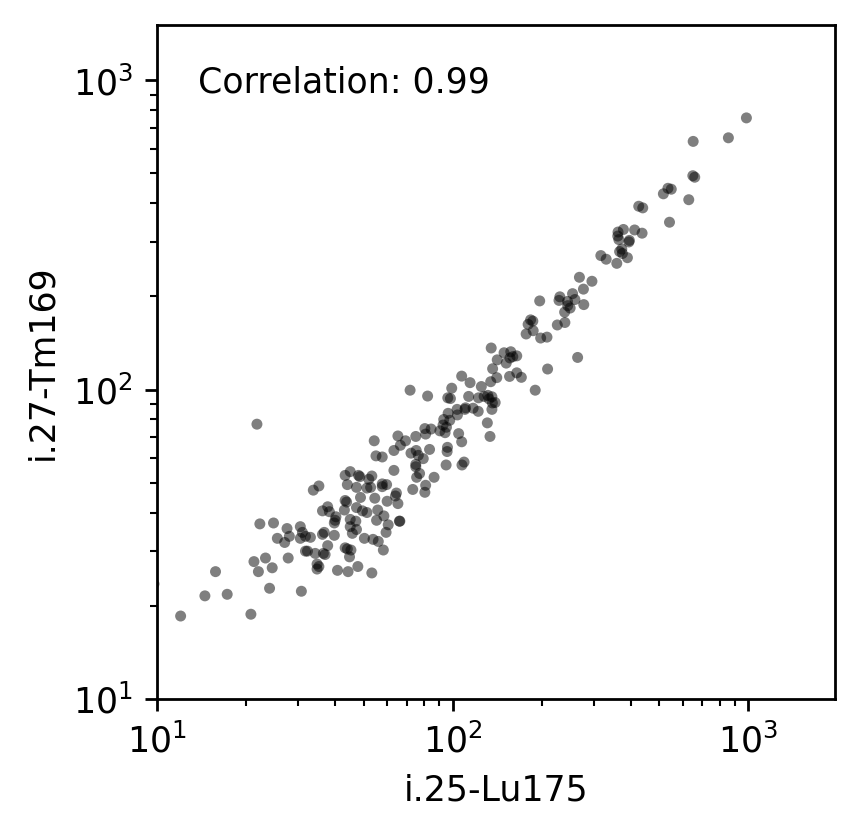

Mean ratio:  1.224163112687334
Median ratio:  1.229559744693099


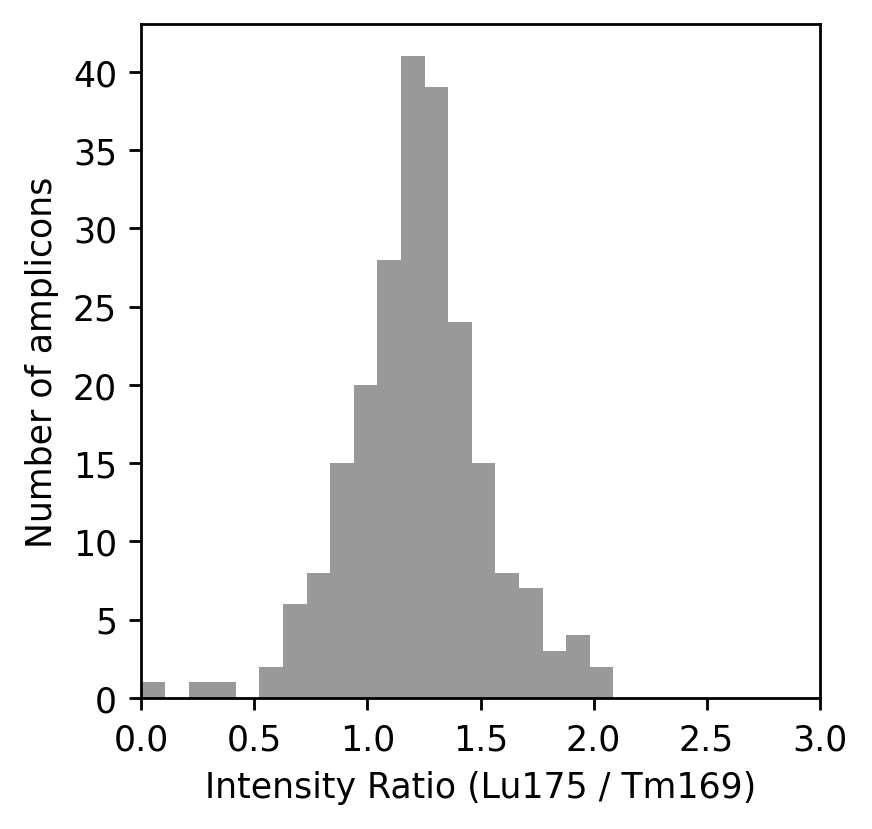

In [17]:
# plot scatter plot of total intensity
plt.figure(figsize=(3.5,3.5), dpi = 250)
plt.scatter(amp_df['total_intensity_488'], amp_df['total_intensity_555'], c='black', s=40, alpha=0.5, marker='.', edgecolors='none')
plt.xlabel('i.25-Lu175')
plt.ylabel('i.27-Tm169')
# plt.title('Amplicon total intensity')
# compute the correlation coefficient
correlation = np.corrcoef(amp_df['total_intensity_488'], amp_df['total_intensity_555'])[0, 1]
plt.text(0.06, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=10)
plt.xlim(10, 2*np.max(amp_df['total_intensity_488']))
plt.ylim(10, 2*np.max(amp_df['total_intensity_555']))
# turn on log scale
plt.xscale('log')
plt.yscale('log')
plt.show()


# print the mean and median of the intensity ratio
mean_ratio = np.mean(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
median_ratio = np.median(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
print('Mean ratio: ', mean_ratio)
print('Median ratio: ', median_ratio)
plt.figure(figsize=(3.5,3.5), dpi = 250)
# plot a smoothened histogram of the intensity ratio
plt.hist(amp_df['total_intensity_488']/amp_df['total_intensity_555'], bins=20,  color='gray', alpha=0.8, density=False)
kde = scipy.stats.gaussian_kde(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
# x = np.linspace(0, 1, 100)
# plt.plot(x, kde(x), color='black', alpha=0.5)
plt.xlim(0,3)
plt.xlabel('Intensity Ratio (Lu175 / Tm169)')
plt.ylabel('Number of amplicons')
# plt.title('Intensity Ratio Distribution')
plt.show()

## Amplicon-dependent analysis

In [18]:
voxel_size = 1

Mean diameter:  4491.508405524797
Median diameter:  3385.137501286538


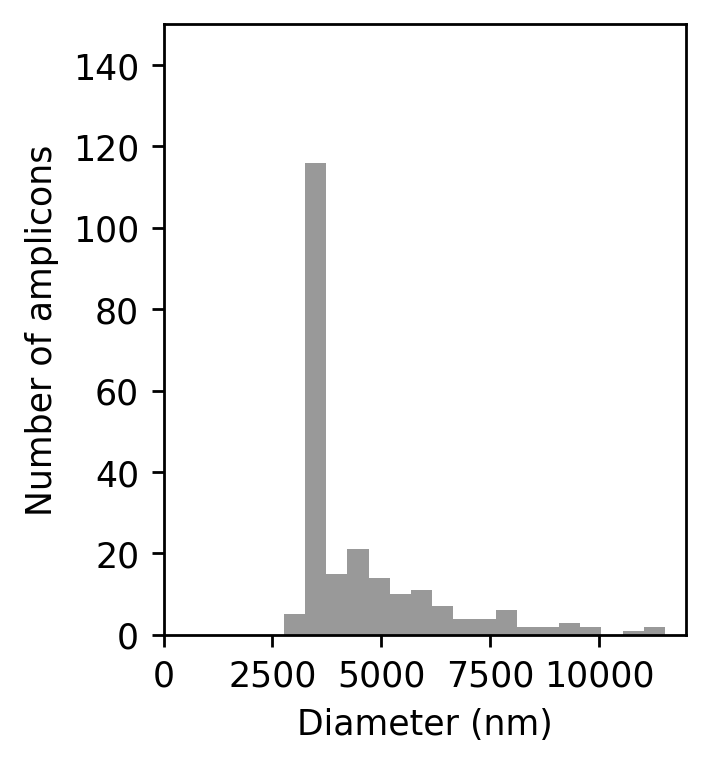

In [20]:
plt.figure(figsize=(3.7,3.7), dpi=250)
# plot a histogram of the area for each amplicon
# plt.subplot(122)
diameter = np.sqrt(amp_df['area']/np.pi) * 2 * voxel_size * 1000
print('Mean diameter: ', np.mean(diameter))
print('Median diameter: ', np.median(diameter))
plt.hist(diameter, bins='auto', color='gray', alpha=0.8, label='Amplicon diameter', density=False)
plt.xlim(0, 12000)
plt.ylim(0, 150)
# plt.title('Amplicon Diameter')

plt.xlabel('Diameter (nm)')
plt.ylabel('Number of amplicons')

# set subplot distance
plt.tight_layout(pad=3.0)
plt.show()


### Compute SNR

Define SNR as mean intensity / std(background)

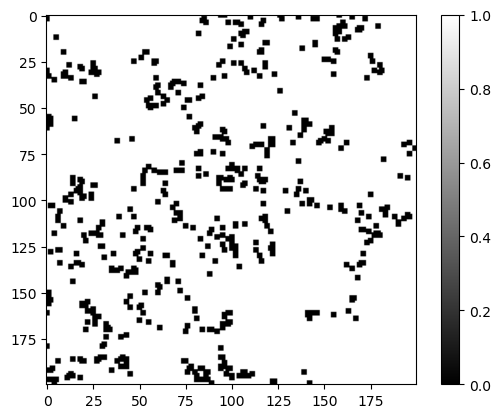

In [23]:
# find the background by inverting the mask
img_mask_bin = img_mask.copy()
img_mask_bin[img_mask_bin > 0] = 1
img_mask_inv = np.invert(img_mask_bin)
# normalize the mask to 0-1
img_mask_inv = (img_mask_inv-img_mask_inv.min())/np.abs(img_mask_inv.max()-img_mask_inv.min())
plt.imshow(img_mask_inv, cmap='gray')
plt.clim(0, 1)
plt.colorbar()

In [24]:
# compute the standard deviation of the background
background_std_555 = np.std(img_555[img_mask_inv > 0])
background_mean_555 = np.mean(img_555[img_mask_inv > 0])
background_std_488 = np.std(img_488[img_mask_inv > 0])
background_mean_488 = np.mean(img_488[img_mask_inv > 0])
print(f"Background mean: {background_mean_555:.2f}, std: {background_std_555:.2f}")
print(f"Background mean: {background_mean_488:.2f}, std: {background_std_488:.2f}")
# add a column to the amp_df for the SNR
amp_df['SNR_555'] = 0
amp_df['SNR_488'] = 0

# compute the SNR for each amplicon
for label in amp_df['label'].tolist():
    # compute the mean intensity of the amplicon
    peak_intensity_555 = img_555[amp_df.loc[amp_df['label'] == label]['y'].astype(int), amp_df.loc[amp_df['label'] == label]['x'].astype(int)]
    peak_intensity_488 = img_488[amp_df.loc[amp_df['label'] == label]['y'].astype(int), amp_df.loc[amp_df['label'] == label]['x'].astype(int)]
    # compute the SNR
    snr_555 = (np.mean(peak_intensity_555) - background_mean_555) / background_std_555
    snr_488 = (np.mean(peak_intensity_488) - background_mean_488) / background_std_488
    # add the SNR to the amp_df
    amp_df.loc[amp_df['label'] == label, 'SNR_555'] = snr_555
    amp_df.loc[amp_df['label'] == label, 'SNR_488'] = snr_488

Background mean: 0.78, std: 1.72
Background mean: 1.16, std: 2.47


/tmp/ipykernel_363720/3779260486.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7071604132652283' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  amp_df.loc[amp_df['label'] == label, 'SNR_555'] = snr_555
/tmp/ipykernel_363720/3779260486.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33766210079193115' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  amp_df.loc[amp_df['label'] == label, 'SNR_488'] = snr_488


In [25]:
amp_df

,label,y,x,area,mean_intensity_488,total_intensity_488,mean_intensity_555,total_intensity_555,SNR_555,SNR_488
0,1,0.500000,95.000000,10.0,5.500000,55.000000,6.100000,60.999999,0.707160,0.337662
1,2,1.000000,110.000000,9.0,3.583333,32.249999,3.333333,29.999999,12.633179,7.210753
2,3,1.461538,126.615385,13.0,8.500000,110.500000,6.711538,87.249998,0.125403,0.741962
3,4,1.000000,136.000000,9.0,3.055556,27.500000,3.944444,35.500000,13.214935,4.582807
4,5,0.500000,158.000000,6.0,5.166667,30.999999,5.750000,34.500000,17.723553,9.636550
...,...,...,...,...,...,...,...,...,...,...
220,221,194.000000,45.000000,9.0,2.305556,20.750000,2.083333,18.749999,9.288076,7.109678
221,222,196.000000,18.000000,9.0,8.583333,77.249997,5.944445,53.500002,16.850918,15.701041
222,223,197.250000,3.125000,24.0,9.968750,239.250000,7.416667,177.999996,24.704638,22.068758
223,224,198.000000,122.500000,12.0,7.979167,95.749998,5.250000,63.000000,9.724394,10.647298


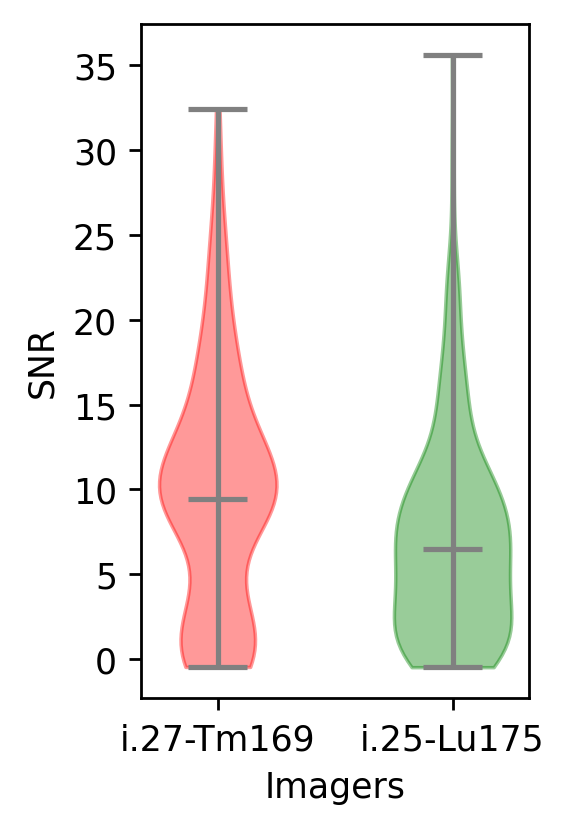

In [26]:
fig, ax = plt.subplots(1,1, figsize=(2., 3.5), dpi=250)
plots = ax.violinplot([amp_df['SNR_555'], amp_df['SNR_488']], showmeans=False, showmedians=True, showextrema=True)
colors = ['red', 'green']
for pc, color in zip(plots['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor(color)
    pc.set_alpha(0.4)
    
# set the color of lines
lw = 1.5
plots['cmedians'].set_edgecolor('gray')
plots['cmedians'].set_linewidth(lw)
plots['cmaxes'].set_edgecolor('gray')
plots['cmaxes'].set_linewidth(lw)
plots['cmins'].set_edgecolor('gray')
plots['cmins'].set_linewidth(lw)
plots['cbars'].set_edgecolor('gray')
plots['cbars'].set_linewidth(lw)

# set x tickes
plt.xticks([1, 2], ['i.27-Tm169', 'i.25-Lu175'])
plt.xlabel('Imagers')
plt.ylabel('SNR')
plt.show()

In [27]:
# save the dataframes to csv
df_dir = os.path.join(data_dir, "dataframes")
if not os.path.exists(df_dir):
    os.makedirs(df_dir)
amp_df.to_csv(os.path.join(df_dir, os.path.basename(file).replace('.tif', '_amp_df.csv')), index=False)

## Nuclear segmentation and visualization

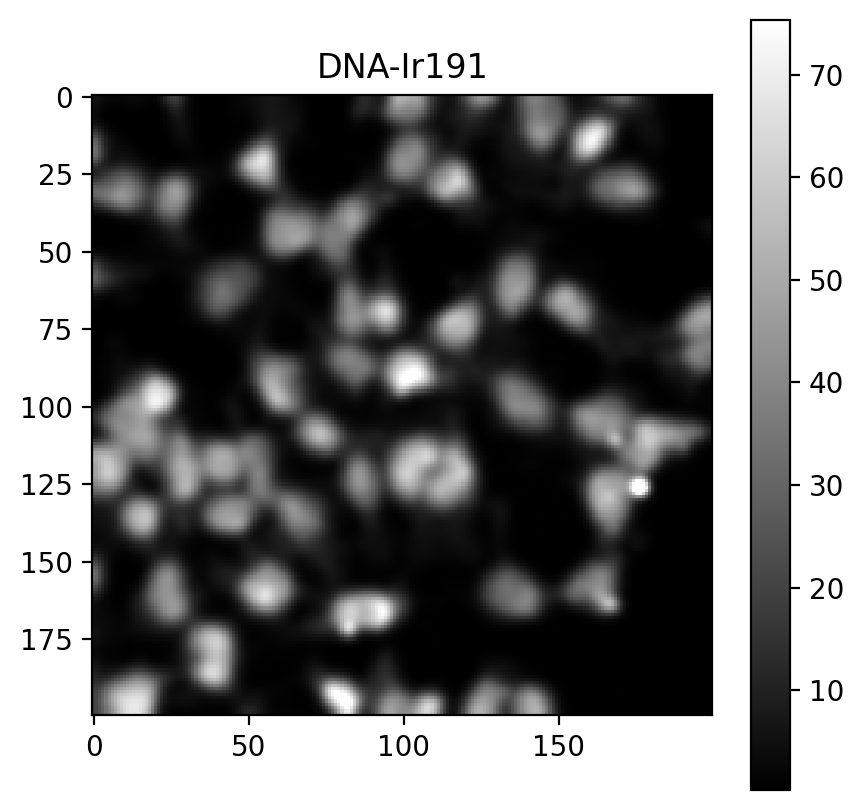

In [79]:
img_nuc = img[11,:,:]

# blur the img_nuc
img_nuc = cv2.GaussianBlur(img_nuc, (0, 0), 2)

plt.figure(figsize=(5,5), dpi=200)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.title("DNA-Ir191")
plt.colorbar()
plt.show()


In [80]:
model_nuc = models.Cellpose(model_type="nuclei")

In [81]:
channels = [[0, 0]]

nmasks, nflows, nstyles, ndiams = model_nuc.eval(img_nuc, diameter=None, channels = channels)

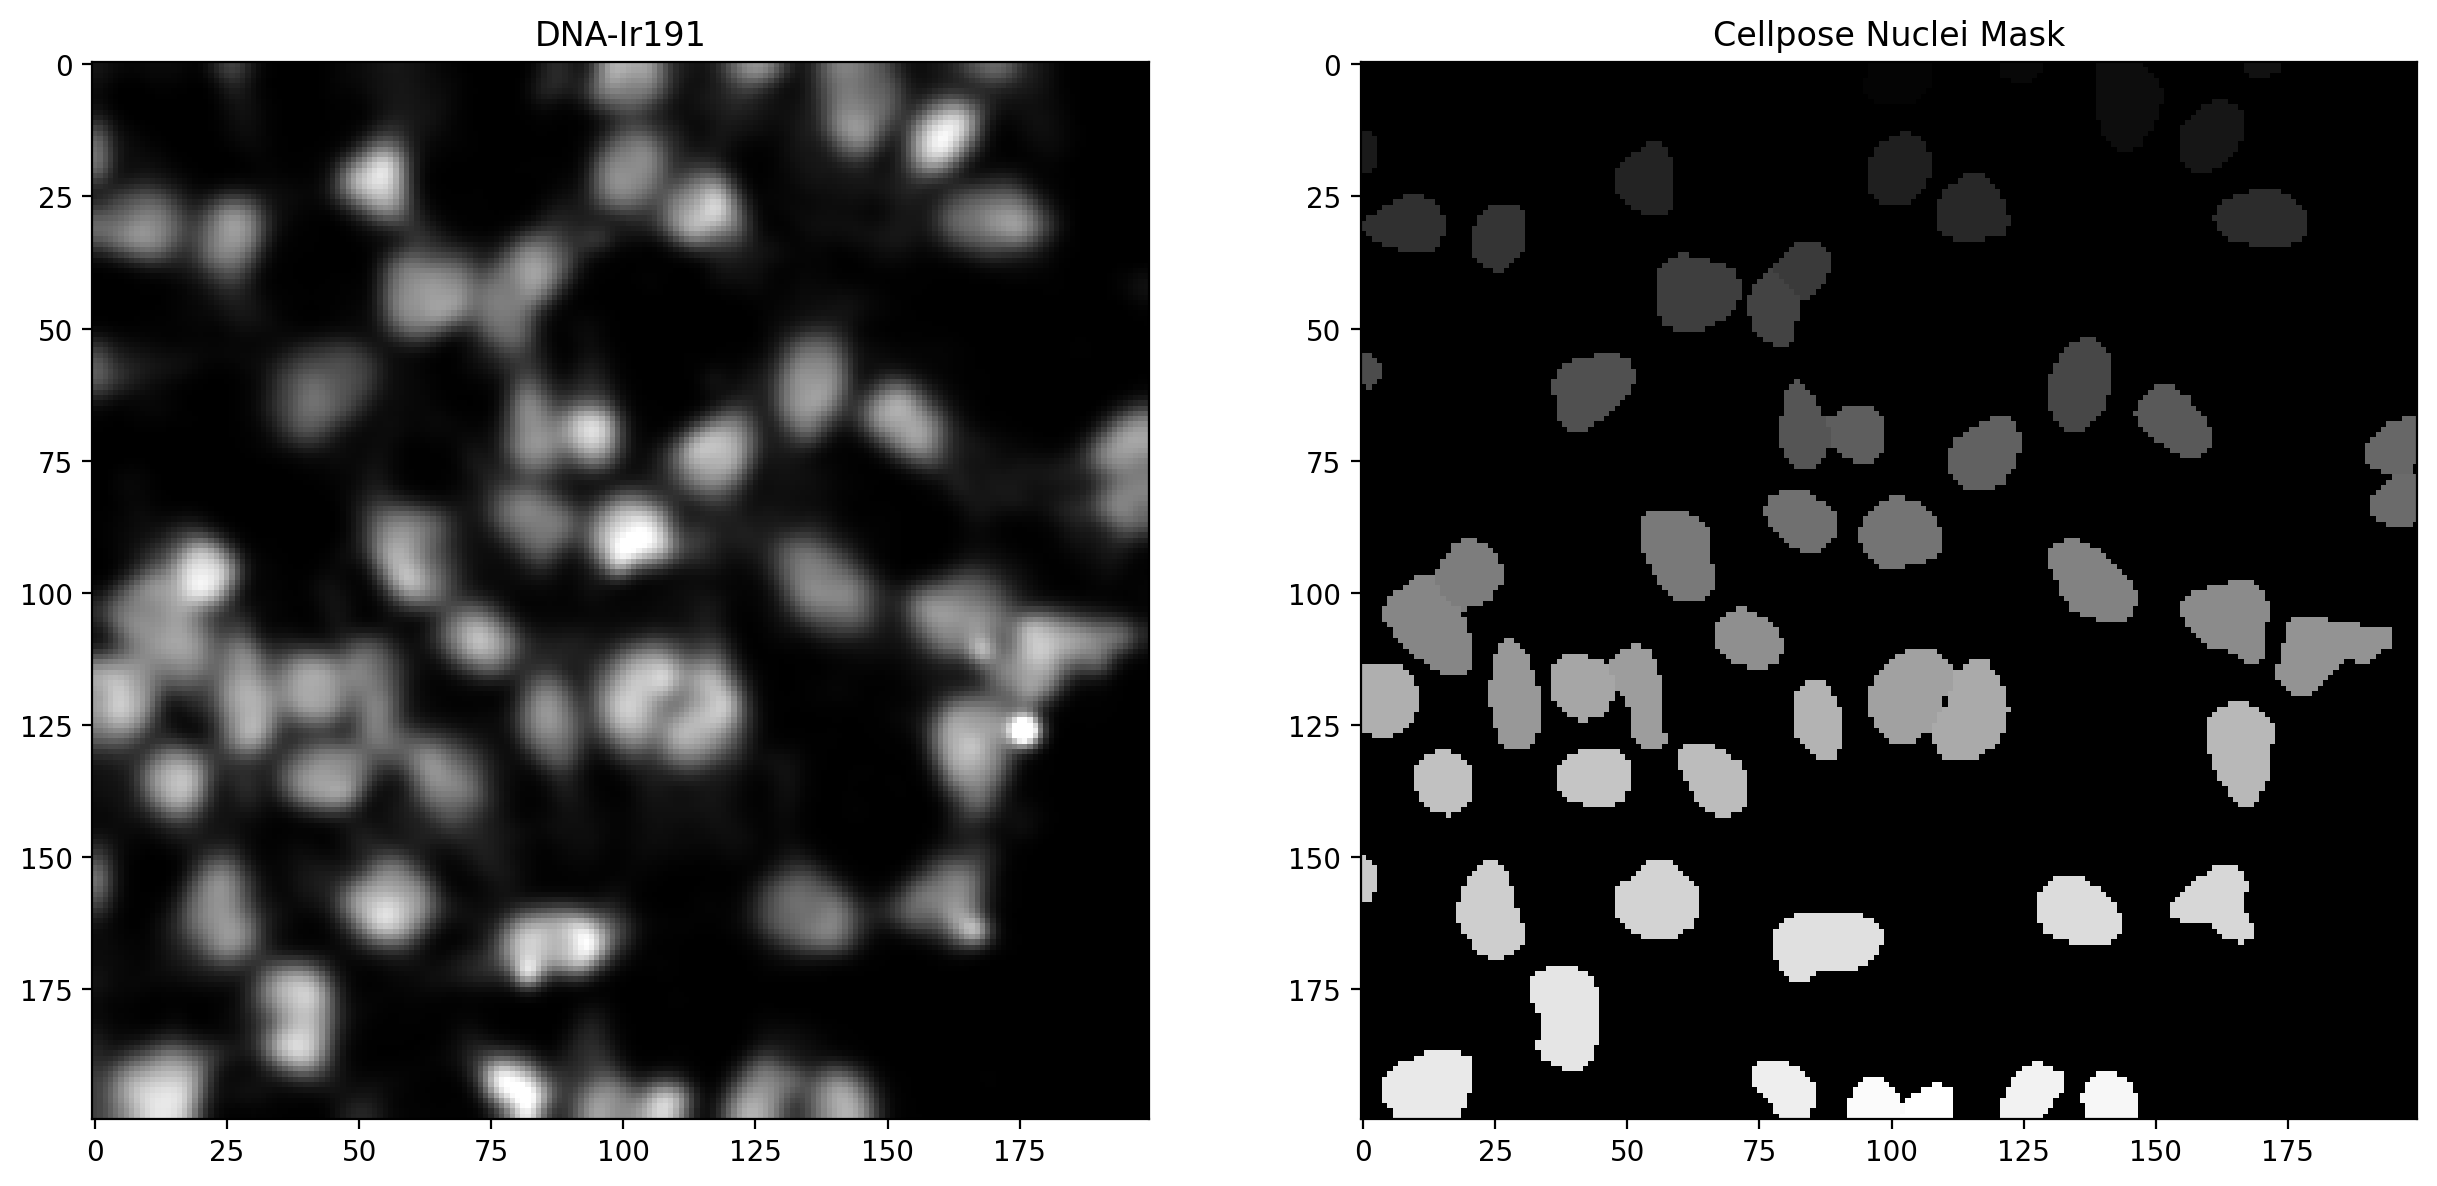

In [82]:
# show the masks
plt.figure(figsize=(15, 15), dpi = 200)

plt.subplot(121)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.title("DNA-Ir191")

plt.subplot(122)
plt.imshow(nmasks, cmap='gray')
plt.title("Cellpose Nuclei Mask")
plt.show()

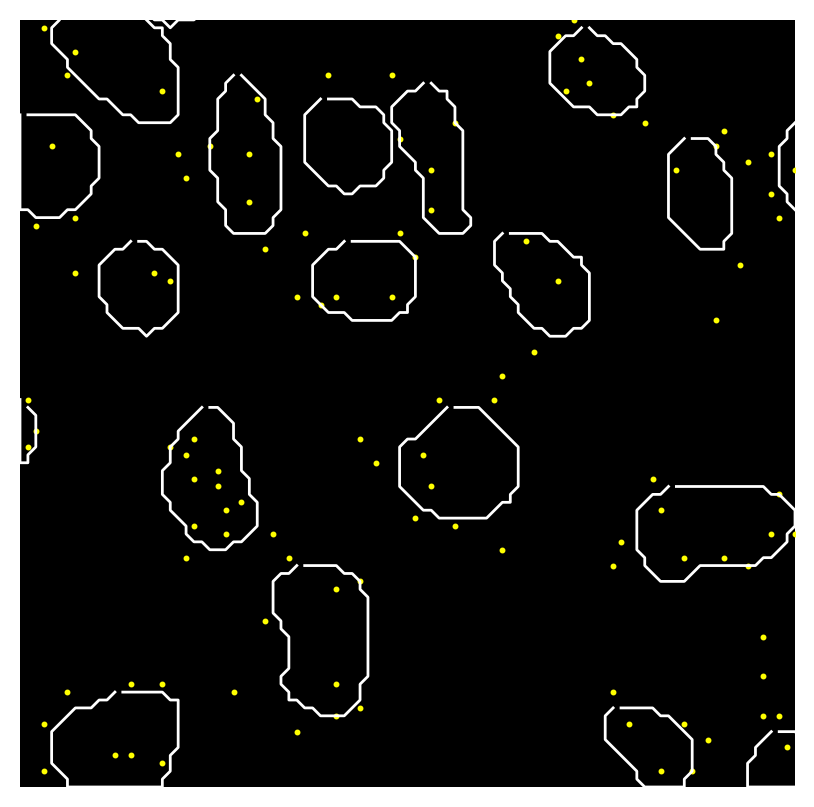

In [86]:
# convert the mask to a contour
bmask_contour = utils.outlines_list(nmasks)

# plot the contour of cmask and bmask on the same image
plt.figure(figsize=(5, 5), dpi=200)
psudo_img = np.zeros_like(img_555)
plt.imshow(psudo_img, cmap='gray', clim=(0, 1))
# plt.imshow(img_555, cmap=cc.cm.fire, clim=(500, 2000))
# add contour of cmask
lw=1
# add contour of bmask
for contour in bmask_contour:
    plt.plot(contour[:, 0], contour[:, 1], color='white', linewidth=lw)
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=5, marker = '.')
# set black background
plt.axis('off')
plt.xlim(0, 98)
plt.ylim(img_555.shape[0]-1, img_555.shape[0]-98)
plt.show()
